In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as tfl

In [2]:
X_orig = np.load('X.npy')
Y_orig = np.load('Y.npy')

X_orig = X_orig/255

X_train, X_test = X_orig, None
Y_train, Y_test = Y_orig, None


print ("number of training examples = " + str(X_train.shape[0]))

#print ("number of test examples = " + str(X_test.shape[0]))

print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))

'''
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
'''

# set the train datasets to the same as in the other notebook
image_list = X_train
mask_list = Y_train

number of training examples = 1080
X_train shape: (1080, 128, 96, 3)
Y_train shape: (1080, 128, 96)


### U NET ARCHITECHTURE ###

1. Contracting Block (downsample/encode)
2. Skip connection (Concatenation)
3. Expanding Block (upsample/decode)
4. Final Feature Mapping (1x1 conv)

In [3]:
# DOWNSAMPLING
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block
    
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection outputs
    """

    ### START CODE HERE
    conv = tfl.Conv2D(n_filters, # Number of filters
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    conv = tfl.Conv2D(n_filters, # Number of filters
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  # set 'kernel_initializer' same as above
                  kernel_initializer='he_normal')(conv)
    ### END CODE HERE
    
    # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
    if dropout_prob > 0:
         ### START CODE HERE
        conv = tfl.Dropout(dropout_prob)(conv)
         ### END CODE HERE
         
    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        ### START CODE HERE
        next_layer = tfl.MaxPooling2D(pool_size=(2, 2))(conv)
        ### END CODE HERE
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

In [4]:
# UPSAMPLING
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """
    Convolutional upsampling block
    
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns: 
        conv -- Tensor output
    """
    
    ### START CODE HERE
    up = tfl.Conv2DTranspose(
                 n_filters,    # number of filters
                 (3,3),    # Kernel size
                 strides = (2,2),
                 padding = 'same')(expansive_input)
    
    # Merge the previous output and the contractive_input
    merge = tfl.concatenate([up, contractive_input], axis=3)
    conv = tfl.Conv2D(n_filters,   # Number of filters
                 (3,3),     # Kernel size
                 activation = 'relu',
                 padding = 'same',
                 kernel_initializer = 'he_normal')(merge)
    conv = tfl.Conv2D(n_filters,  # Number of filters
                 (3,3),   # Kernel size
                 activation = 'relu',
                 padding = 'same',
                  # set 'kernel_initializer' same as above
                 kernel_initializer = 'he_normal')(conv)
    ### END CODE HERE
    
    return conv

In [5]:
from tensorflow.keras.models import Model

In [6]:
def unet_model(input_size=(128, 96, 3), n_filters=32):
    """
    Unet model
    
    Arguments:
        input_size -- Input shape 
        n_filters -- Number of filters for the convolutional layers
    Returns: 
        model -- tf.keras.Model
    """
    inputs = tfl.Input(input_size)
    # Contracting Path (encoding)
    # Add a conv_block with the inputs of the unet_ model and n_filters
    ### START CODE HERE
    cblock1 = conv_block(inputs, n_filters)
    # Chain the first element of the output of each block to be the input of the next conv_block. 
    # Double the number of filters at each new step
    cblock2 = conv_block(cblock1[0], n_filters*2)
    cblock3 = conv_block(cblock2[0], n_filters*4)
    cblock4 = conv_block(cblock3[0], n_filters*8, dropout_prob=0.3) # Include a dropout_prob of 0.3 for this layer
    # Include a dropout_prob of 0.3 for this layer, and avoid the max_pooling layer
    cblock5 = conv_block(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False) 
    ### END CODE HERE
    
    # Expanding Path (decoding)
    # Add the first upsampling_block.
    # Use the cblock5[0] as expansive_input and cblock4[1] as contractive_input and n_filters * 8
    ### START CODE HERE
    ublock6 = upsampling_block(cblock5[0], cblock4[1],  n_filters*8)
    # Chain the output of the previous block as expansive_input and the corresponding contractive block output.
    # Note that you must use the second element of the contractive block i.e before the maxpooling layer. 
    # At each step, use half the number of filters of the previous block 
    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters*4)
    ublock8 = upsampling_block(ublock7, cblock2[1],  n_filters*2)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters)
    ### END CODE HERE

    conv9 = tfl.Conv2D(n_filters,
                 3,
                 activation='linear',
                 padding='same',
                 # set 'kernel_initializer' same as above exercises
                 kernel_initializer='he_normal')(ublock9)

    # Add a Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding
    ### START CODE HERE
    conv10 = tfl.Conv2D(1, 1, padding='same')(conv9)
    ### END CODE HERE
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [7]:
model = unet_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 128, 96, 3)        │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 128, 96, 32)       │             896 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 128, 96, 32)       │           9,248 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 64, 48, 32)        │               0 │ conv2d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 64, 48, 64)        │          18,496 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 64, 48, 64)        │          36,928 │ conv2d_2[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 32, 24, 64)        │               0 │ conv2d_3[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 32, 24, 128)       │          73,856 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_5 (Conv2D)             │ (None, 32, 24, 128)       │         147,584 │ conv2d_4[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_2               │ (None, 16, 12, 128)       │               0 │ conv2d_5[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_6 (Conv2D)             │ (None, 16, 12, 256)       │         295,168 │ max_pooling2d_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_7 (Conv2D)             │ (None, 16, 12, 256)       │         590,080 │ conv2d_6[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 16, 12, 256)       │               0 │ conv2d_7[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_3               │ (None, 8, 6, 256)         │               0 │ dropout[0][0]              │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_8 (Conv2D)             │ (None, 8, 6, 512)         │       1,180,160 │ max_pooling2d_3[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_9 (Conv2D)             │ (None, 8, 6, 512)         │       2,359,80

 Total params: 8,639,745 (32.96 MB)

 Trainable params: 8,639,745 (32.96 MB)

 Non-trainable params: 0 (0.00 B)

In [126]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(weight_decay=0.001), loss="mae", metrics=['mae'])

In [127]:
EPOCHS = 40
BATCH_SIZE = 16
model_history = model.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=EPOCHS)

Epoch 1/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - loss: 466.9214 - mae: 466.9214
Epoch 2/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 160s 2s/step - loss: 411.3678 - mae: 411.3679
Epoch 3/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - loss: 404.2604 - mae: 404.2604
Epoch 4/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 158s 2s/step - loss: 383.0972 - mae: 383.0972
Epoch 5/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - loss: 359.3261 - mae: 359.3260
Epoch 6/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 160s 2s/step - loss: 359.8463 - mae: 359.8463
Epoch 7/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - loss: 348.7435 - mae: 348.7435
Epoch 8/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - loss: 341.2401 - mae: 341.2401
Epoch 9/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - loss: 358.5084 - mae: 358.5084
Epoch 10/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - loss: 323.0051 - mae: 323.0051
Epoch 11/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 149s 2s/step - loss: 336.5908 - mae: 336.5908
Epoch 12/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 155s 2s/step - loss: 324.1682 - mae

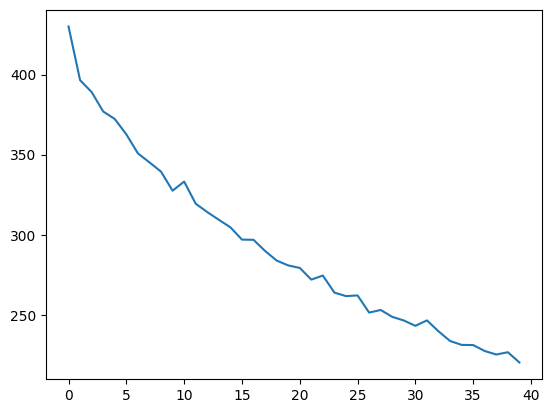

In [128]:
plt.plot(model_history.history['mae'])

In [129]:
Y_train[1].shape

(128, 96)

In [132]:
def show_predictions(images, ground_truth, num=1):
    
    test_predict = np.reshape(images[num], (1, 128, 96, 3))
    test_truth = np.reshape(ground_truth[num], (1, 128, 96, 1))
    prediction = model.predict(test_predict)
    evaluation = model.evaluate(test_predict, test_truth)

    fig, arr = plt.subplots(1, 3, figsize=(14, 7))
    arr[0].imshow(images[num])
    arr[0].set_title('Original Image')

    arr[1].imshow(ground_truth[num], vmax=np.max(ground_truth[num]), vmin=np.min(ground_truth[num]))
    arr[1].set_title('Ground Truth Map')
    
    arr[2].imshow(prediction[0, :, :, :], vmax=np.max(ground_truth[num]), vmin=np.min(ground_truth[num]))
    arr[2].set_title('Predicted Map')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 169.0042 - mae: 169.0042


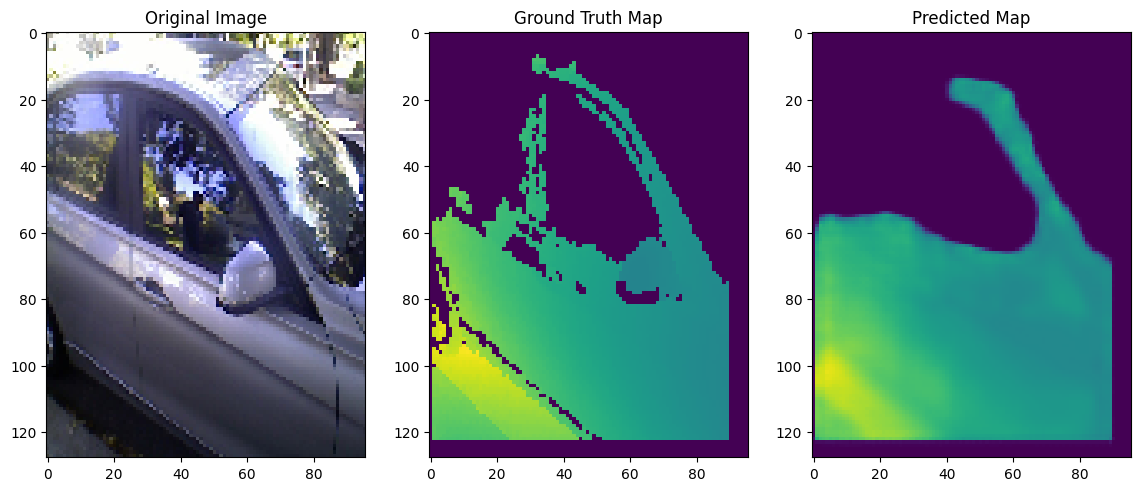

In [141]:
show_predictions(X_train, Y_train, num=578)